In [1]:
import numpy as np
from fetch_data import get_data, remove_cols
from helper import *
from getters_alpaca import *
from ucimlrepo import fetch_ucirepo 
import torch
import torch.nn as nn

In [2]:
# get data
iris = fetch_ucirepo(id=53) 
  
X = iris.data.features 
y = iris.data.targets 
x_numpy = np.array(X)
y_numpy = np.array(y)

# Combine features and targets into a single array and shuffle them
data = np.column_stack((x_numpy, y_numpy))
np.random.shuffle(data)

x_numpy = data[:, :-1]
y_numpy = data[:, -1]

# Replacing plant names with corresponding numbers
label_encoder = pd.factorize(y_numpy.flatten())[1]
for i, name in enumerate(label_encoder):
    y_numpy[y_numpy == name] = i


m, n = x_numpy.shape # 150 x 4

x_train= torch.tensor(x_numpy[0:120].astype(float), dtype=torch.float)
y_train= torch.tensor(y_numpy[0:120].astype(float), dtype=torch.float)
x_test=torch.tensor(x_numpy[120:m].astype(float), dtype=torch.float)
y_test= torch.tensor(y_numpy[120:m].astype(float), dtype=torch.float)

In [47]:
class LinearRegresionModel(nn.Module):
    def __init__(self, in_features=4, l1 = 10, l2=10):
        super().__init__()
        self.weights1 = nn.Parameter(torch.randn(in_features, l1, dtype=torch.float), requires_grad=True)
        self.bias1 = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        
        self.weights2 = nn.Parameter(torch.randn(l1, l2, dtype=torch.float), requires_grad=True)
        self.bias2 = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        
        self.weights3 = nn.Parameter(torch.randn(l2, dtype=torch.float), requires_grad=True)
        self.bias3 = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        
    def forward(self, x) -> torch.Tensor:
       # print(f'{x.shape} x {self.weights1.size()}') 120 x 4
        x = torch.matmul(x, self.weights1) + self.bias1
        x = torch.relu(x)
       # print(f'{x.shape} x {self.weights2.size()}')
        x = torch.matmul(x, self.weights2) + self.bias2
        x = torch.relu(x)
       # print(f'{x.shape} x {self.weights2.size()}')
        x = torch.matmul(x, self.weights3) + self.bias3
       # print(x.shape)
        return x

In [57]:
torch.manual_seed(1)
model = LinearRegresionModel()

In [58]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
loss_fn = nn.L1Loss() 

In [59]:
epochs = 1000
losses = []
test_losses = []
for epoch in range(epochs):
    y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train)
    losses.append(torch.mean(loss).detach().numpy())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    with torch.inference_mode():
      test_pred = model(x_test)
      test_loss = loss_fn(test_pred, y_test)
      test_losses.append(torch.mean(test_loss).detach().numpy())
      
      # Print the average loss every few epochs
    if (epoch + 1) % 100 == 0:  # Print every 10 epochs
        print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {loss}, Test avg loss: {test_loss}')
        


Epoch [100/1000], Average Loss: 0.49110743403434753, Test avg loss: 0.2775043845176697
Epoch [200/1000], Average Loss: 0.4618937075138092, Test avg loss: 0.2953614294528961
Epoch [300/1000], Average Loss: 0.4535676836967468, Test avg loss: 0.30938541889190674
Epoch [400/1000], Average Loss: 0.4463776648044586, Test avg loss: 0.30838698148727417
Epoch [500/1000], Average Loss: 0.4380851686000824, Test avg loss: 0.31168773770332336
Epoch [600/1000], Average Loss: 0.4264431893825531, Test avg loss: 0.3113112151622772
Epoch [700/1000], Average Loss: 0.40866413712501526, Test avg loss: 0.28539127111434937
Epoch [800/1000], Average Loss: 0.3941357433795929, Test avg loss: 0.26510608196258545
Epoch [900/1000], Average Loss: 0.3813706040382385, Test avg loss: 0.25716808438301086
Epoch [1000/1000], Average Loss: 0.3681757152080536, Test avg loss: 0.24687914550304413


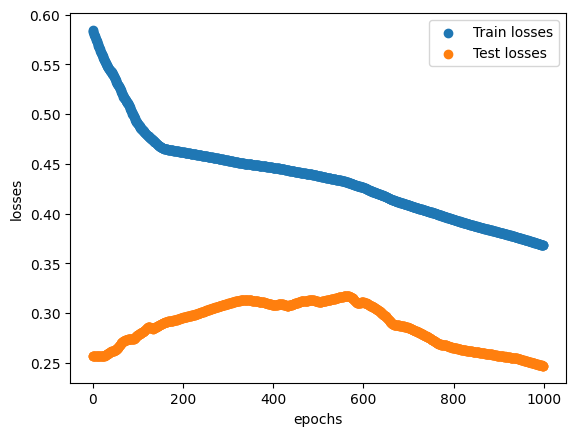

In [60]:
import matplotlib.pyplot as plt
plt.scatter(range(epochs), losses, label='Train losses')
plt.scatter(range(epochs), test_losses, label='Test losses')
plt.xlabel("epochs")
plt.ylabel("losses")
plt.legend()
plt.show()

In [61]:
correctGuesses = 0
for i, item in enumerate(x_test):
    with torch.inference_mode():
        y_preds = model(item)
        correct = y_test[i]
        guess = ""
        if y_preds < 0.5:
             guess = 0
        elif y_preds < 1.5:
            guess = 1
        else: guess = 2
        
        if (int(correct) == guess): 
            correctGuesses+=1
        else: print(f'wrong!!!!: {y_preds}')
        print(f'expected: {int(correct)}, guessed: {guess}')
print(f'{correctGuesses}/30')
        

expected: 1, guessed: 1
wrong!!!!: tensor([1.3084])
expected: 0, guessed: 1
expected: 0, guessed: 0
expected: 1, guessed: 1
expected: 0, guessed: 0
expected: 1, guessed: 1
expected: 0, guessed: 0
expected: 1, guessed: 1
wrong!!!!: tensor([1.4955])
expected: 2, guessed: 1
expected: 0, guessed: 0
wrong!!!!: tensor([1.4955])
expected: 2, guessed: 1
wrong!!!!: tensor([1.4955])
expected: 0, guessed: 1
expected: 0, guessed: 0
expected: 1, guessed: 1
expected: 1, guessed: 1
expected: 1, guessed: 1
wrong!!!!: tensor([1.4955])
expected: 2, guessed: 1
expected: 0, guessed: 0
expected: 0, guessed: 0
expected: 1, guessed: 1
expected: 1, guessed: 1
expected: 0, guessed: 0
expected: 0, guessed: 0
expected: 0, guessed: 0
wrong!!!!: tensor([1.4955])
expected: 2, guessed: 1
expected: 1, guessed: 1
wrong!!!!: tensor([1.4955])
expected: 2, guessed: 1
expected: 1, guessed: 1
wrong!!!!: tensor([0.8036])
expected: 0, guessed: 1
expected: 0, guessed: 0
22/30
